# Load Data

In [2]:
import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

## Plot Data

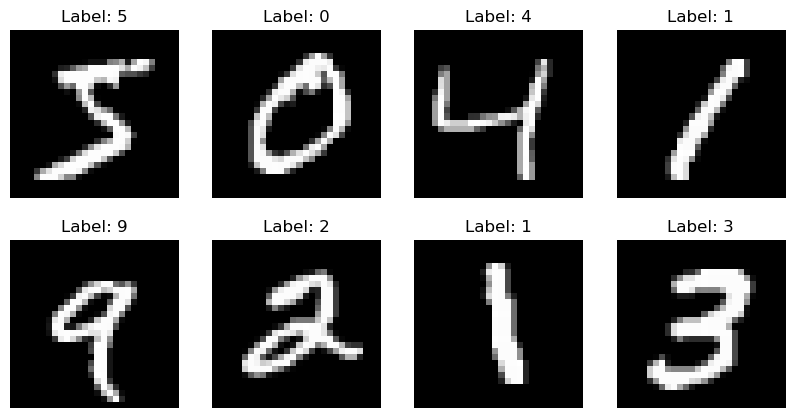

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')

plt.show()

In [4]:
# Check the shape of the data
# Each image is 28 x 28 pixels
print(x_train[1].shape)

(28, 28)


# Random Forest

## Data Prep

In [5]:
# Many machine learning models expect data to be in a 2D table, where each row is a sample and each column is a feature.
# We can flatten the 28x28 images into a single row of 784 pixels.

# So, first we need to prepare/alter the images so that a random forest can use them.
# The random forest will use the pixel values as features, so give it a dataset of flat vectors like
# the one we used for the fashion_mnist example.

x_train_flat = x_train.reshape(x_train.shape[0], -1)
print(x_train_flat.shape)
print(y_train.shape)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

(60000, 784)
(60000,)


In [6]:
# There are 10 classes in the MNIST dataset, just like the fashion_MNIST.
# You need to select 3 classes to train your model on. You get to pick the classes you want to use, but 
# Please choose classes that are similar to each other.
# For example, you could choose 3, 5, and 8. Or 4, 7, 9. Or other combinations that you deam appropriate.
# Please don't choose digits that are easy to tell apart, like 0, 1, and 5. Or 1, 2, and 3.

# You can totally copy code over from the fmnist_examples notebook and modify it.
# You can use chatGPT, copilot, google, or other AI or online resources.
# Use each other, the goal is to complete the objective and maybe learn something new, not to struggle to make up code on your own.
# We have prior notebooks, chatGPT, the internet, and each other for the rapids projects, so use them here if they will help!

# Extract the 3 classes from the training data
# Extract 7s, 0s, and 9s from the training data (sneakers and ankle boots)
train_filter = (y_train == 7) | (y_train == 9) | (y_train == 0)
x_train_7_9_0 = x_train_flat[train_filter]
y_train_7_9_0 = y_train[train_filter]

# Extract the 3 classes from the test data
# Extract 7s, 0s, and 9s from the test data
test_filter = (y_test == 7) | (y_test == 9) | (y_test == 0)
x_test_7_9_0 = x_test_flat[test_filter]
y_test_7_9_0 = y_test[test_filter]

# Maybe check the shape of the data is correct
print(f'x_train_7_9_0 shape: {x_train_7_9_0.shape}')
print(f'y_train_7_9_0 shape: {y_train_7_9_0.shape}')
print(f'x_test_7_9_0 shape: {x_test_7_9_0.shape}')
print(f'y_test_7_9_0 shape: {y_test_7_9_0.shape}')

x_train_7_9_0 shape: (18137, 784)
y_train_7_9_0 shape: (18137,)
x_test_7_9_0 shape: (3017, 784)
y_test_7_9_0 shape: (3017,)


## Simple Model Fit

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Fit a simple random forest. Make sure it has at least 100 trees, Probably not more than 1000 trees.
rf.fit(x_train_7_9_0, y_train_7_9_0)

y_test_pred = rf.predict(x_test_7_9_0)

# Generate predictions on the test set and calculate the overall accuracy of the model on the test set.
# Calculate the accuracy on the test data
test_accuracy = accuracy_score(y_test_7_9_0, y_test_pred)
print(f'Test Accuracy: {test_accuracy}') 

Test Accuracy: 0.9900563473649321


# Tune Model Fit

In [8]:
# Now try to tuning the model. 
# This part can take a while, maybe several minutes.
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for mtry (max_features in sklearn)
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [100, 200, 300]
}

# Initialize the RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, random_state=42)

# Initialize GridSearchCV with the RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(x_train_7_9_0, y_train_7_9_0)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Best cross-validation score: {best_score}')


# Generate predictions on the test set and calculate the overall accuracy of the model on the test set.
# Use the best estimator to make predictions
best_rf = grid_search.best_estimator_
y_test_pred = best_rf.predict(x_test_7_9_0)


# Does tuning the model improve the accuracy? How much? This actually made it less accurate lol... This could be a me problem though.
# Was the tuning accuracy worth the extra time?

Best parameters: {'max_features': 'sqrt', 'n_estimators': 300}
Best cross-validation score: 0.9884214890830105


Test Accuracy: 0.9900563473649321
[[ 978    1    1]
 [   3 1015   10]
 [   9    6  994]]


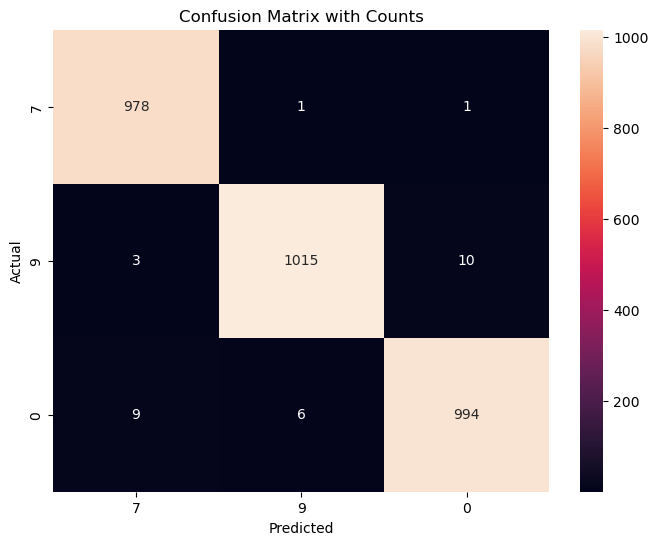

In [8]:
# Compute and plot a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Calculate the accuracy on the test data
test_accuracy = accuracy_score(y_test_7_9_0, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_7_9_0, y_test_pred)
print(conf_matrix)

# Where are misclassifications occurring?
# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=[7, 9, 0], yticklabels=[7, 9, 0])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts')
plt.show()

[[0.    1.    0.   ]
 [0.995 0.005 0.   ]
 [0.    0.055 0.945]
 [0.005 0.065 0.93 ]
 [0.995 0.    0.005]]


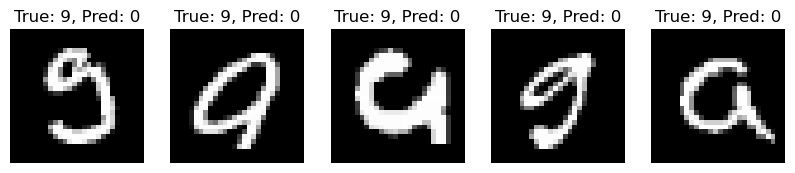

In [9]:
# Plot some of the misclassifications.
# Find the indices of misclassified samples
y_test_pred_proba = rf.predict_proba(x_test_7_9_0)
print(y_test_pred_proba[:5])
misclassified_indices = [i for i in range(len(y_test_7_9_0)) if y_test_pred[i] != y_test_7_9_0[i]]

# Calculate the probabilities of the predicted class for misclassified samples
misclassified_probs = [y_test_pred_proba[idx][1] if y_test_7_9_0[idx] == 7 else y_test_pred_proba[idx][0] for idx in misclassified_indices]

# Get the indices of the 5 worst misclassifications (highest probabilities for the wrong class)
worst_misclassified_indices = [misclassified_indices[i] for i in sorted(range(len(misclassified_probs)), key=lambda i: misclassified_probs[i], reverse=True)[:5]]

# Plot the 5 worst misclassified samples
plt.figure(figsize=(10, 5))

for i, idx in enumerate(worst_misclassified_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_test_7_9_0[idx].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_test_7_9_0[idx]}, Pred: {y_test_pred[idx]}')
    plt.axis('off')

plt.show()

# Can you see why the model made the misclassifications it did?